In [42]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import csv
from google.colab import drive
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.metrics import BigramAssocMeasures
import string
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
import re
from scipy import stats
from nltk.sentiment import SentimentIntensityAnalyzer
from tabulate import tabulate
from wordcloud import WordCloud
from gensim import corpora, models
import ast
from collections import defaultdict
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
import seaborn as sns
from transformers import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Data Collection

In [2]:
import requests
from bs4 import BeautifulSoup
import csv
import re

def scrape_transcript_to_csv(url, csv_file_path, debate_number):
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = soup.find_all('p')

        speaker_names, times, texts, debates = [], [], [], []
        current_speaker, current_time = None, None

        for paragraph in paragraphs:
            match = re.match(r'^(.*?)\((.*?)\):(.*)', paragraph.text)
            if match:
                current_speaker, current_time, text = match.groups()
                speaker_names.append(current_speaker.strip())
                times.append(current_time.strip())
                texts.append(text.strip())
                debates.append(debate_number)  # Add the debate number
            else:
                if current_speaker and texts:
                    texts[-1] += ' ' + paragraph.text.strip()

        if not speaker_names or not times or not texts:
            print("Failed to extract data correctly.")
            return

        data = list(zip(speaker_names, times, texts, debates))

        write_mode = 'w' if debate_number == 1 else 'a'
        with open(csv_file_path, write_mode, newline='', encoding='utf-8') as csvfile:
            csv_writer = csv.writer(csvfile)
            if debate_number == 1:
                csv_writer.writerow(['speaker', 'time', 'text', 'debate'])
            csv_writer.writerows(data)

        print(f"Data from {url} appended to CSV file: {csv_file_path}")
    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")

In [3]:
drive.mount("/drive", force_remount=True)

urls = [
    "https://www.rev.com/blog/transcripts/fox-news-republican-presidential-primary-debate-transcript",
    "https://www.rev.com/blog/transcripts/second-republican-presidential-primary-debate-transcript",
    "https://www.rev.com/blog/transcripts/rnc-third-republican-presidential-primary-debate-transcript"
]

output_filepath = '/drive/My Drive/Colab Notebooks/IST 664/Final project/debates.csv'

for i, url in enumerate(urls, start=1):
    scrape_transcript_to_csv(url, output_filepath, i)

Mounted at /drive
Data from https://www.rev.com/blog/transcripts/fox-news-republican-presidential-primary-debate-transcript appended to CSV file: /drive/My Drive/Colab Notebooks/IST 664/Final project/debates.csv
Data from https://www.rev.com/blog/transcripts/second-republican-presidential-primary-debate-transcript appended to CSV file: /drive/My Drive/Colab Notebooks/IST 664/Final project/debates.csv
Data from https://www.rev.com/blog/transcripts/rnc-third-republican-presidential-primary-debate-transcript appended to CSV file: /drive/My Drive/Colab Notebooks/IST 664/Final project/debates.csv


In [4]:
all_debates = pd.read_csv(output_filepath)

all_debates.head()

,speaker,time,text,debate
0,Speaker 1,14:55,"Some call it the heartland. Others, fly over ...",1
1,Bret Baier,16:45,"Tonight, the race for the White House takes f...",1
2,Martha Maccallum,16:58,Eight Republican candidates have qualified an...,1
3,Bret Baier,17:15,I’m Bret Baier. This is the very same stage o...,1
4,Martha Maccallum,17:40,"Next, entrepreneur, Vivek Ramaswamy.",1


### Preprocessing

In [5]:
# https://www.nytimes.com/interactive/2023/us/politics/debate-republican-candidates-qualify.html
# consider candidates only participants that were involved in all debate rounds. other are moderators
candidates = ['Ron DeSantis', 'Nikki Haley', 'Vivek Ramaswamy', 'Chris Christie', 'Tim Scott']
# replace the speaker label with moderator if not in candidate list
all_debates['speaker'] = all_debates['speaker'].apply(lambda x: x if x in candidates else 'moderator')
# focus on speakers only
df = all_debates[all_debates['speaker'] != 'moderator']
# merge the data by speaker
df = df.groupby('speaker')['text'].apply(' '.join).reset_index()

In [6]:
def preprocess_text(text):
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    stop_words_set = set(stopwords.words('english'))
    processed_sentences = []

    # Tokenize each sentence into words and perform POS tagging
    tagged_tokens = pos_tag(word_tokenize(text))

    # Lowercase tokens (except proper nouns), remove punctuation and numbers,
    # and filter out short words
    tokens = [(w.lower() if tag not in ('NNP', 'NNPS') else w, tag) for w, tag in tagged_tokens if w.isalpha() and len(w) > 3]

    # Remove stopwords
    tokens = [(w, tag) for w, tag in tokens if w not in stop_words_set]

    # Lemmatize tokens based on POS tags
    lemmatized_tokens = [(lemmatizer.lemmatize(w), tag) for w, tag in tokens]

    # POS filtering for topic modeling: select only nouns and verbs
    processed_tokens = [w for w, tag in lemmatized_tokens if tag.startswith('NN') or tag.startswith('VB')]

    return processed_tokens

In [7]:
df['processed_text'] = df['text'].apply(lambda x: preprocess_text(x))

In [8]:
df.head()

,speaker,text,processed_text
0,Chris Christie,"Well, look, I do agree predominantly with wha...","[look, Governor, DeSantis, laid, think, asked,..."
1,Nikki Haley,"Well, I don’t care about polls. What I care a...","[care, poll, care, fact, telling, people, trut..."
2,Ron DeSantis,Our country is in decline. This decline is no...,"[country, decline, decline, choice, need, send..."
3,Tim Scott,"Well, thank you for the question. Over the la...","[thank, question, year, opportunity, vote, spe..."
4,Vivek Ramaswamy,"So first, let me just address a question that...","[address, question, everybody, mind, home, ton..."


In [9]:
# Create bigrams
all_tokens = [tokens for tokens in df['processed_text']]
bigram_model = Phrases(all_tokens, min_count=10, threshold=100)
bigram_mod = Phraser(bigram_model)

###Topic Modeling

In [10]:
# Prepare data with bigrams for topic modeling
texts_by_candidate = defaultdict(list)
for _, row in df.iterrows():
    speaker = row['speaker']
    tokens = bigram_mod[row['processed_text']]  # Apply bigram model
    texts_by_candidate[speaker].extend(tokens)

In [11]:
# Create dictionary and corpus
dictionary = corpora.Dictionary(texts_by_candidate.values())
dictionary.filter_extremes(no_below=2, no_above=0.7, keep_n=100000)
corpus = [dictionary.doc2bow(texts) for texts in texts_by_candidate.values()]

In [12]:
# Check the first few documents in the corpus to ensure they are not empty
for doc in corpus[:5]:
    print(doc)

[(0, 3), (1, 2), (2, 2), (3, 1), (4, 4), (5, 1), (6, 1), (7, 1), (8, 3), (9, 2), (10, 1), (11, 4), (12, 5), (13, 2), (14, 1), (15, 2), (16, 2), (17, 1), (18, 5), (19, 1), (20, 1), (21, 2), (22, 2), (23, 1), (24, 2), (25, 1), (26, 1), (27, 3), (28, 1), (29, 1), (30, 1), (31, 2), (32, 13), (33, 2), (34, 2), (35, 1), (36, 1), (37, 3), (38, 4), (39, 1), (40, 1), (41, 1), (42, 2), (43, 2), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 2), (50, 3), (51, 2), (52, 4), (53, 2), (54, 1), (55, 2), (56, 2), (57, 2), (58, 1), (59, 4), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 3), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 2), (75, 1), (76, 3), (77, 2), (78, 2), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 5), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 6), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 2), (101, 1), (102, 1), (103, 1), (104, 1), (105, 2), (106, 4), (107, 2), (108, 2), (109, 1), (110, 1)

In [13]:
# Train the LDA model on the corpus
lda_model = models.LdaModel(corpus, num_topics=15, id2word=dictionary, passes=15, alpha = 'symmetric', eta = 'auto')

In [14]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_by_candidate.values(), dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()

print(f'Coherence Score: {coherence_score}')

Coherence Score: 0.3202162839742098


In [15]:
# Gather the topic distribution for each speaker
topics_by_speaker = {speaker: lda_model.get_document_topics(bow) for speaker, bow in zip(texts_by_candidate.keys(), corpus)}

In [16]:
# Function to format the topics in a more readable way
def format_topics(topics):
    return [f"Topic {topic_num+1}: {prob:.2%}" for topic_num, prob in topics]

In [17]:
# Apply the formatting function to the topic distribution
formatted_topics = {speaker: format_topics(topics) for speaker, topics in topics_by_speaker.items()}

formatted_topics

{'Chris Christie': ['Topic 12: 99.72%'],
 'Nikki Haley': ['Topic 9: 14.62%', 'Topic 14: 85.25%'],
 'Ron DeSantis': ['Topic 8: 80.43%', 'Topic 12: 19.37%'],
 'Tim Scott': ['Topic 4: 99.70%'],
 'Vivek Ramaswamy': ['Topic 6: 4.32%', 'Topic 8: 11.46%', 'Topic 9: 84.13%']}

In [18]:
# Function to display the topics with real words
def show_topics(lda_model, num_words=10):
    for idx, topic in lda_model.print_topics(-1, num_words=num_words):
        print(f"Topic {idx + 1}: {topic}")

# Display the topics with real words for each candidate
show_topics(lda_model)

Topic 1: 0.002*"answer" + 0.002*"truth" + 0.002*"Israel" + 0.002*"union" + 0.002*"Senate" + 0.002*"tonight" + 0.002*"Russia" + 0.002*"Iran" + 0.002*"finish" + 0.002*"policy"
Topic 2: 0.002*"answer" + 0.002*"finish" + 0.002*"Senate" + 0.002*"truth" + 0.002*"company" + 0.002*"nation" + 0.002*"Russia" + 0.002*"party" + 0.002*"Florida" + 0.002*"Israel"
Topic 3: 0.002*"answer" + 0.002*"generation" + 0.002*"party" + 0.002*"company" + 0.002*"making" + 0.002*"Russia" + 0.002*"policy" + 0.002*"address" + 0.002*"Israel" + 0.002*"Florida"
Topic 4: 0.020*"nation" + 0.017*"finish" + 0.017*"household" + 0.014*"Senate" + 0.014*"NATO" + 0.014*"doubt" + 0.012*"leave" + 0.012*"fire" + 0.012*"loan" + 0.012*"unemployment"
Topic 5: 0.002*"Florida" + 0.002*"decline" + 0.002*"answer" + 0.002*"company" + 0.002*"medium" + 0.002*"somebody" + 0.002*"support" + 0.002*"price" + 0.002*"generation" + 0.002*"choose"
Topic 6: 0.026*"criminal" + 0.026*"help" + 0.025*"citizen" + 0.025*"employee" + 0.024*"night" + 0.013*

###Topic Labeling

In [19]:
# Assuming 'lda_model', 'dictionary', and 'corpus' are already created with bigram-enhanced data

# Function to get top words/bigrams for each topic
def get_top_words_with_bigrams(lda_model, num_words=10):
    top_words_bigrams = {}
    for topic_id in range(lda_model.num_topics):
        # Extracting words and their probabilities
        top_words_bigrams[topic_id] = [(dictionary[word_id], prob) for word_id, prob in lda_model.get_topic_terms(topic_id, topn=num_words)]
    return top_words_bigrams

# Extract top words/bigrams for each topic
top_words_bigrams_per_topic = get_top_words_with_bigrams(lda_model)

# Function to create labels from top words/bigrams
def create_label_from_bigrams(top_words_bigrams):
    # Selecting the top word or bigram as label
    return ' '.join([word for word, prob in top_words_bigrams[:2]])

# Create labels for each topic
topic_labels_with_bigrams = {topic_id: create_label_from_bigrams(words_bigrams) for topic_id, words_bigrams in top_words_bigrams_per_topic.items()}

topic_labels_with_bigrams

{0: 'answer truth',
 1: 'answer finish',
 2: 'answer generation',
 3: 'nation finish',
 4: 'Florida decline',
 5: 'criminal help',
 6: 'Florida answer',
 7: 'Florida decline',
 8: 'generation party',
 9: 'Florida Iran',
 10: 'company Israel',
 11: 'answer tonight',
 12: 'Florida decline',
 13: 'Iran Russia',
 14: 'Senate nation'}

In [20]:
# Determine the dominant topic for each candidate
dominant_topic_by_candidate = {}
for speaker, bow in zip(texts_by_candidate.keys(), corpus):
    speaker_topics = lda_model.get_document_topics(bow)
    dominant_topic = max(speaker_topics, key=lambda x: x[1])[0]
    dominant_topic_by_candidate[speaker] = dominant_topic

# Function to create labels from top words/bigrams for a given topic
def create_label_from_bigrams(topic_id, top_words_bigrams):
    return ' '.join([word for word, prob in top_words_bigrams[topic_id][:2]])

# Create labels for each candidate's dominant topic
labels_by_candidate = {}
for speaker, topic_id in dominant_topic_by_candidate.items():
    labels_by_candidate[speaker] = create_label_from_bigrams(topic_id, top_words_bigrams_per_topic)

labels_by_candidate

{'Chris Christie': 'answer tonight',
 'Nikki Haley': 'Iran Russia',
 'Ron DeSantis': 'Florida decline',
 'Tim Scott': 'nation finish',
 'Vivek Ramaswamy': 'generation party'}

###Vizualization

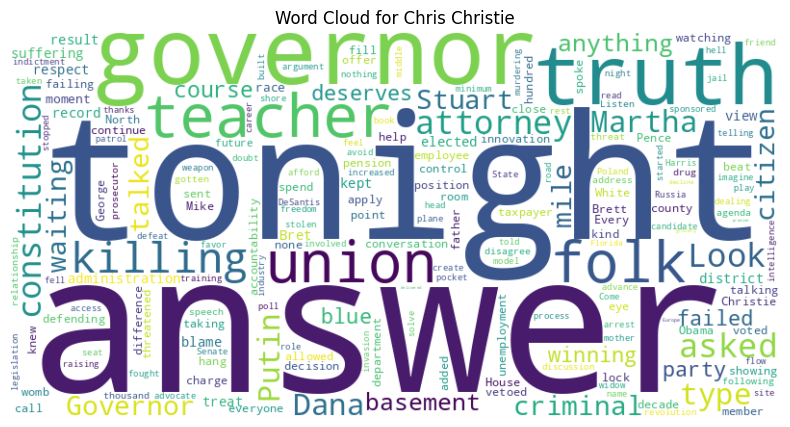

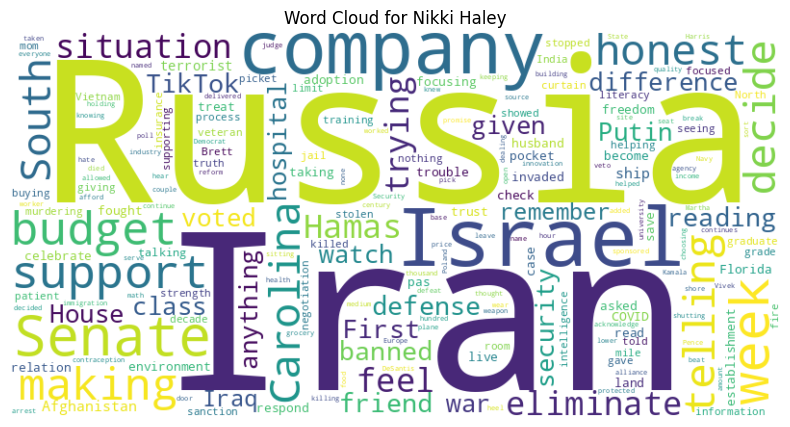

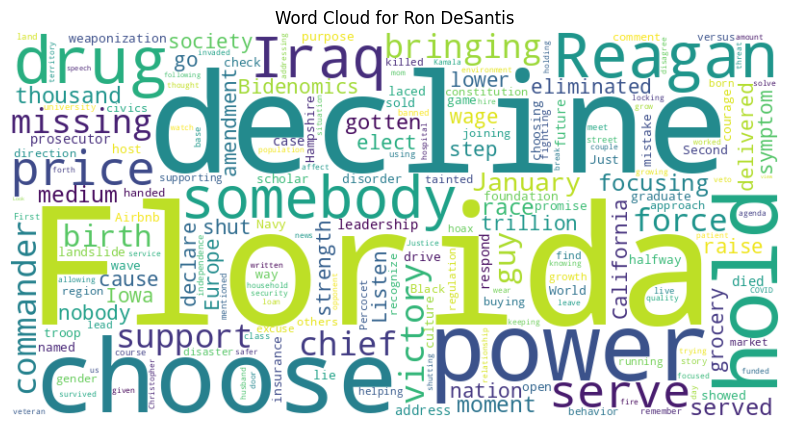

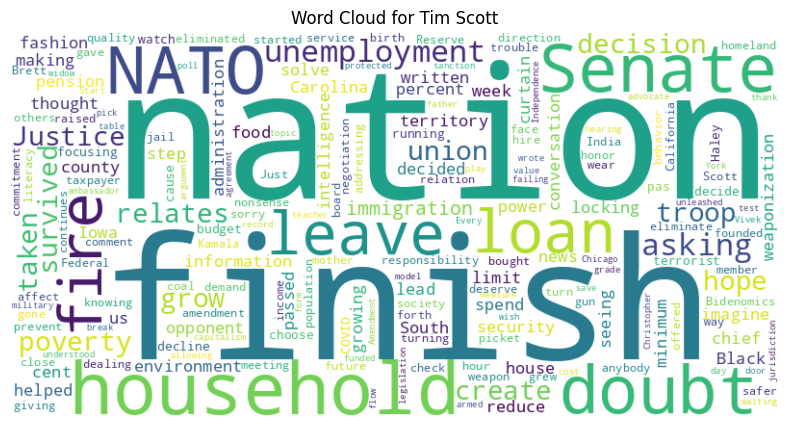

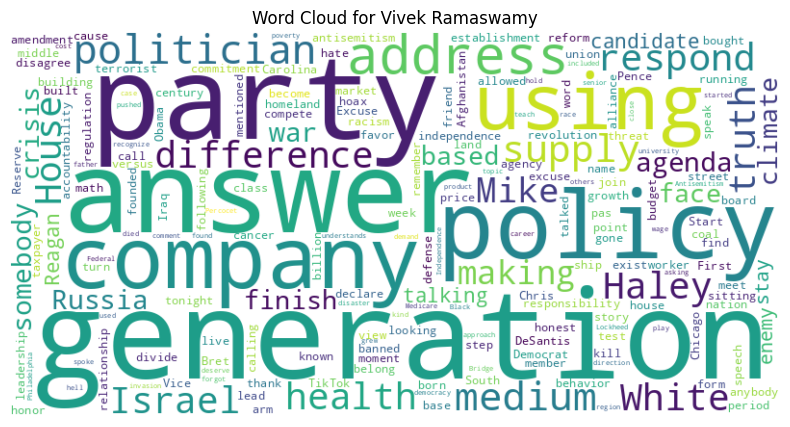

In [21]:
# Generate word clouds based on the topics modeled for each candidate
for speaker, bow in zip(texts_by_candidate.keys(), corpus):
    # Get the topic distribution for the speaker's text
    speaker_topics = lda_model.get_document_topics(bow, minimum_probability=0.5)

    # Aggregate word probabilities across all topics for the speaker
    word_probs = {word: 0 for word in dictionary.values()}
    for topic_num, prob in speaker_topics:
        for word_id, word_prob in lda_model.get_topic_terms(topic_num, topn=len(dictionary)):
            word_probs[dictionary[word_id]] += prob * word_prob

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_probs)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {speaker}')
    plt.axis('off')
    plt.show()

<ipython-input-22-2f66a33fd6cc>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_distributions = topic_distributions.append(topic_distribution, ignore_index=True)
<ipython-input-22-2f66a33fd6cc>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_distributions = topic_distributions.append(topic_distribution, ignore_index=True)
<ipython-input-22-2f66a33fd6cc>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_distributions = topic_distributions.append(topic_distribution, ignore_index=True)
<ipython-input-22-2f66a33fd6cc>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_distributions = topic_distributions.append(topic_d

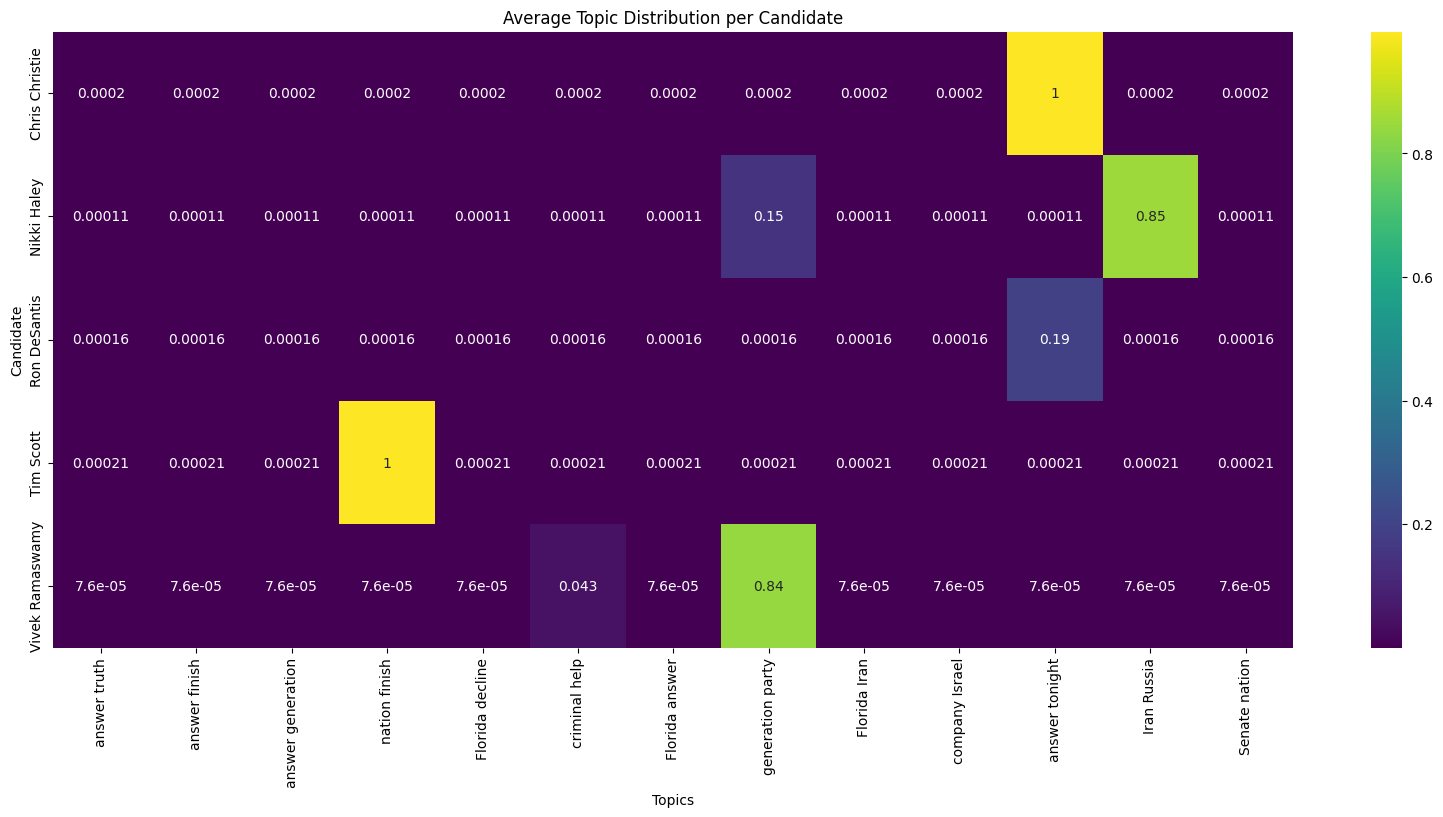

In [22]:
# Function to get the topic distribution for each candidate
def get_topic_distribution_by_candidate(lda_model, corpus, candidates):
    topic_distributions = pd.DataFrame()

    for bow, candidate in zip(corpus, candidates):
        topic_probabilities = lda_model.get_document_topics(bow, minimum_probability=0)
        topic_distribution = {topic_labels_with_bigrams[topic]: prob for topic, prob in topic_probabilities}
        topic_distribution['candidate'] = candidate
        topic_distributions = topic_distributions.append(topic_distribution, ignore_index=True)

    return topic_distributions

# Get topic distribution by candidate
topic_distributions = get_topic_distribution_by_candidate(lda_model, corpus, texts_by_candidate.keys())

# Average the topic distribution for each candidate
average_topic_distribution = topic_distributions.groupby('candidate').mean()

# Creating the heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(average_topic_distribution, annot=True, cmap='viridis')
plt.title('Average Topic Distribution per Candidate')
plt.xlabel('Topics')
plt.ylabel('Candidate')
plt.show()

<ipython-input-23-598aeaec625e>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_distributions = topic_distributions.append(topic_distribution, ignore_index=True)
<ipython-input-23-598aeaec625e>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_distributions = topic_distributions.append(topic_distribution, ignore_index=True)
<ipython-input-23-598aeaec625e>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_distributions = topic_distributions.append(topic_distribution, ignore_index=True)
<ipython-input-23-598aeaec625e>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_distributions = topic_distributions.append(topic_d

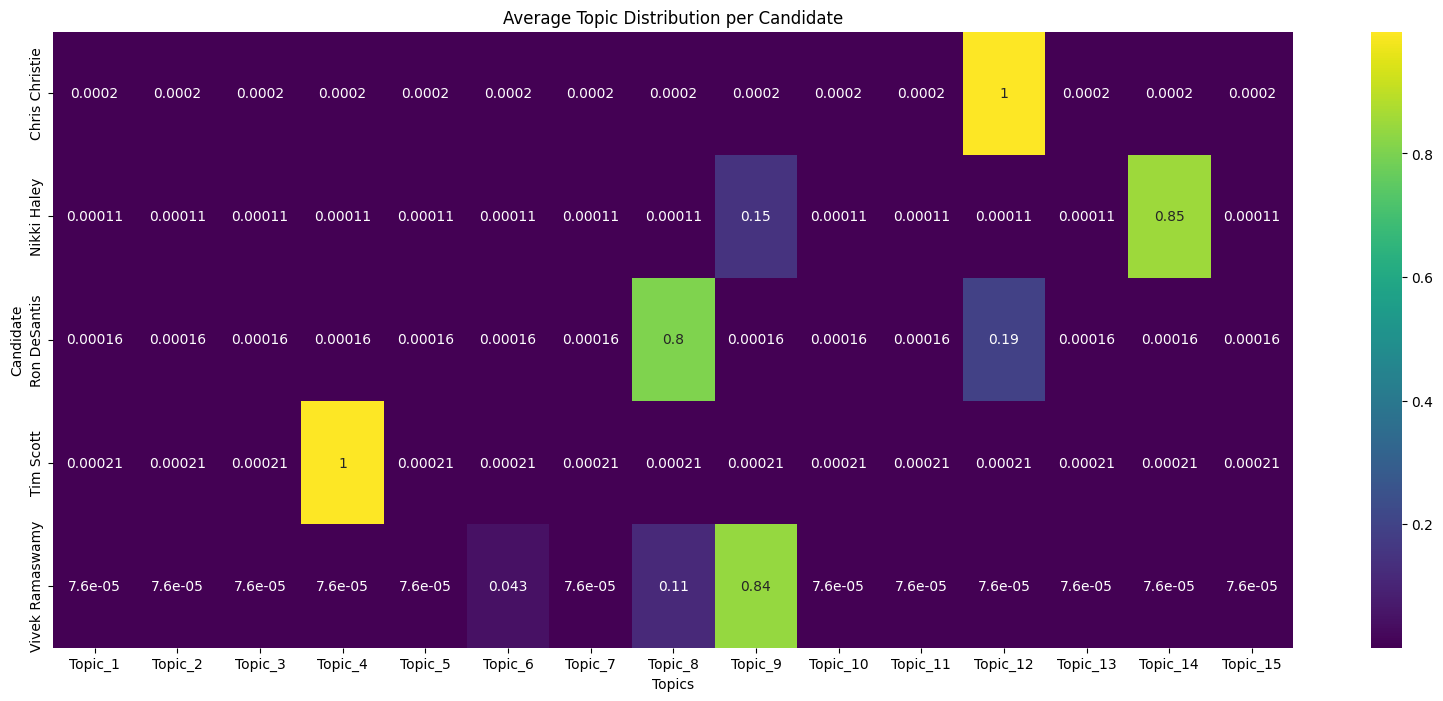

In [23]:
# Function to get the topic distribution for each candidate
def get_topic_distribution_by_candidate(lda_model, corpus, candidates):
    topic_distributions = pd.DataFrame()

    for bow, candidate in zip(corpus, candidates):
        topic_probabilities = lda_model.get_document_topics(bow, minimum_probability=0)
        topic_distribution = {f"Topic_{topic+1}": prob for topic, prob in topic_probabilities}
        topic_distribution['candidate'] = candidate
        topic_distributions = topic_distributions.append(topic_distribution, ignore_index=True)

    return topic_distributions

# Get topic distribution by candidate
topic_distributions = get_topic_distribution_by_candidate(lda_model, corpus, texts_by_candidate.keys())

# Average the topic distribution for each candidate
average_topic_distribution = topic_distributions.groupby('candidate').mean()

# Creating the heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(average_topic_distribution, annot=True, cmap='viridis')
plt.title('Average Topic Distribution per Candidate')
plt.xlabel('Topics')
plt.ylabel('Candidate')
plt.show()

###Sentiment analysis

In [24]:
# pip install transformers

In [25]:
# Assuming your dataset has 'text' for text and 'speaker' for the candidate's name
texts = df['processed_text'].astype(str)
candidates = df['speaker']

In [26]:
sentiment_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [27]:
# Function to split text into chunks
def split_into_chunks(text, max_len=512):
    words = text.split()
    chunks = []
    current_chunk = []
    current_len = 0
    for word in words:
        if current_len + len(word) < max_len:
            current_chunk.append(word)
            current_len += len(word) + 1
        else:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_len = len(word)
    chunks.append(' '.join(current_chunk))  # Add the last chunk
    return chunks

In [28]:
def analyze_sentiment(text):
    chunks = split_into_chunks(text)
    sentiments = [sentiment_pipeline(chunk) for chunk in chunks]
    avg_sentiment = sum([s[0]['score'] for s in sentiments]) / len(sentiments)
    return sentiments[0][0]['label'], avg_sentiment

In [29]:
# Analyze sentiment for each text and store by candidate
sentiments_by_candidate = {}
for text, candidate in zip(texts, candidates):
    sentiment, confidence = analyze_sentiment(text)
    sentiments_by_candidate.setdefault(candidate, []).append((sentiment, confidence))

sentiments_by_candidate

{'Chris Christie': [('NEGATIVE', 0.8912828167279562)],
 'Nikki Haley': [('NEGATIVE', 0.9237688329484728)],
 'Ron DeSantis': [('NEGATIVE', 0.9322866591913946)],
 'Tim Scott': [('POSITIVE', 0.8979649657294864)],
 'Vivek Ramaswamy': [('NEGATIVE', 0.889262999649401)]}

###Fake news detection

In [30]:
# pip install transformers[torch]

In [58]:
# load the labeled dataset

# https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
# 0 = fake and 1 = real
train_dataset = pd.read_csv('/drive/My Drive/Colab Notebooks/IST 664/Final project/WELFake_Dataset.csv').drop(['Unnamed: 0'], axis=1)
train_dataset = train_dataset[['text', 'label']][:10000]

In [59]:
# Drop rows with NaN values in 'text' and 'label' columns
train_dataset = train_dataset.dropna(subset=['text', 'label'])

In [60]:
train_dataset.head()

,text,label
0,No comment is expected from Barack Obama Membe...,1
1,Did they post their votes for Hillary already?,1
2,"Now, most of the demonstrators gathered last ...",1
3,A dozen politically active pastors came here f...,0
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [61]:
# Assuming the training dataset has 'statement' and 'label' columns
X = train_dataset['text']
y = train_dataset['label']

In [62]:
y_train

9254    0
1561    1
1670    1
6087    0
6669    0
       ..
5734    1
5191    1
5390    1
860     0
7270    0
Name: label, Length: 8000, dtype: int64

In [63]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
# Create a pipeline with a TF-IDF vectorizer and an SVM classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svm', SVC(probability=True))
])

In [65]:
# Train the classifier on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('svm', SVC(probability=True))])

In [66]:
# Predict labels on the test set
y_pred = pipeline.predict(X_test)

In [68]:
# Print a full classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       951
           1       0.89      0.95      0.92      1048

    accuracy                           0.91      1999
   macro avg       0.92      0.91      0.91      1999
weighted avg       0.92      0.91      0.91      1999



In [71]:
text = df['processed_text'].astype(str)

In [72]:
df['predicted_labels'] = pipeline.predict(text)

In [73]:
honesty_by_speaker = df.groupby('speaker')['predicted_labels'].agg(lambda x: x.value_counts().idxmax())
honesty_by_speaker

speaker
Chris Christie     1
Nikki Haley        1
Ron DeSantis       1
Tim Scott          1
Vivek Ramaswamy    1
Name: predicted_labels, dtype: int64